In [88]:
import cv2
import numpy as np
import os
import os.path as osp
from PIL import Image
import torchvision
import matplotlib.pyplot as plt

In [65]:
def ann2box(ann, img, multi_contour_eval=True):
    height, width = ann.shape
    ann[ann > 0] = 255
    contours, hierarchy = cv2.findContours(
        image=ann,
        mode=cv2.RETR_TREE,
        method=cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return np.asarray([[0, 0, 0, 0]]), 1
    # print(hierarchy)
    print(len(contours))
    img2 = img.copy()
    # for idx, contour in enumerate(contours):
    #     print(idx)
    # color = np.random.randint(0, 255, (3, )).tolist()
    cv2.drawContours(img2, contours, 9, (255, 0, 0), 5)
    plt.imshow(img2[:, :, ::-1])
    plt.show()
    if not multi_contour_eval:
        contours = [max(contours, key=cv2.contourArea)]
    estimated_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        x0, y0, x1, y1 = x, y, x + w, y + h
        x1 = min(x1, width - 1)
        y1 = min(y1, height - 1)
        estimated_boxes.append([x0, y0, x1, y1])
    return estimated_boxes

In [66]:
pwd

'/home/ashun/Projects/mmsegmentation/tools/diffusemade'

In [67]:
root = '../../data/DiffuseMade10'
img_dir = 'img_dir/train'
ann_dir = 'out_combine/out_ann_dir/tanh2-0.25-4.0-dcrf-0.05-0.95'
name = '00016518.png'
img_path = osp.join(root, img_dir, name)
ann_path = osp.join(root, ann_dir, name)

img = cv2.imread(img_path, cv2.IMREAD_COLOR)
ann = cv2.imread(ann_path, cv2.IMREAD_GRAYSCALE)

17


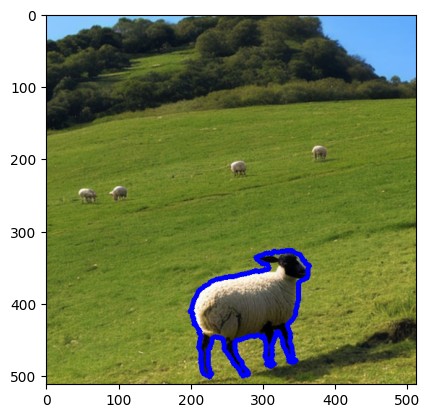

[[218, 511, 219, 511], [289, 496, 290, 497], [306, 493, 307, 494], [315, 490, 316, 491], [315, 487, 316, 488], [344, 474, 345, 475], [277, 457, 278, 459], [357, 338, 358, 339], [348, 329, 349, 330], [199, 327, 365, 503], [311, 479, 314, 482], [361, 349, 364, 352], [44, 240, 71, 262], [86, 237, 114, 260], [251, 201, 279, 225], [366, 180, 391, 204], [372, 200, 375, 203]]


In [68]:
boxes = ann2box(ann, img, multi_contour_eval=True)
print(boxes)

In [75]:
def intersection_area(boxA, boxB):
    # 计算两个矩形框的交集面积
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    if xB < xA or yB < yA:
        return 0
    return (xB - xA + 1) * (yB - yA + 1)


def box_area(box):
    return (box[2] - box[0] + 1) * (box[3] - box[1] + 1)


def union_area(boxA, boxB):
    # 计算两个矩形框的并集面积
    areaA = box_area(boxA)
    areaB = box_area(boxB)
    return areaA + areaB - intersection_area(boxA, boxB)


def is_box_covered(box1, box2):
    # 判断box1是否被box2完全覆盖
    if box1[0] >= box2[0] and box1[1] >= box2[1] and box1[2] <= box2[2] and box1[3] <= box2[3]:
        return True
    else:
        return False


def nms_boxes(boxes, min_area=0):
    sorted_boxes = list(zip(boxes, [box_area(box) for box in boxes]))
    sorted_boxes = sorted(sorted_boxes, key=lambda b: b[1], reverse=True)
    if min_area > sorted_boxes[-1][1]:
        i = 0
        while min_area <= sorted_boxes[i][1]:
            i += 1
        sorted_boxes = sorted_boxes[:i]

    print(sorted_boxes)

    sorted_boxes = list(zip(*sorted_boxes))[0]
    removed = [False] * len(sorted_boxes)
    maximum = 0
    while maximum < len(sorted_boxes):
        if not removed[maximum]:
            for j in range(maximum + 1, len(sorted_boxes)):
                if not removed[j] and is_box_covered(sorted_boxes[j], sorted_boxes[maximum]):
                    removed[j] = True
        maximum += 1
    rtn_boxes = [box for i, box in enumerate(sorted_boxes) if not removed[i]]
    return rtn_boxes


In [70]:
def draw_boxes(img, boxes):
    img2 = img.copy()
    color = (255, 0, 0)
    for box in boxes:
        cv2.rectangle(img2, tuple(box[:2]), tuple(box[2:]), color, 5)
    plt.imshow(img2[:, :, ::-1])
    plt.show()

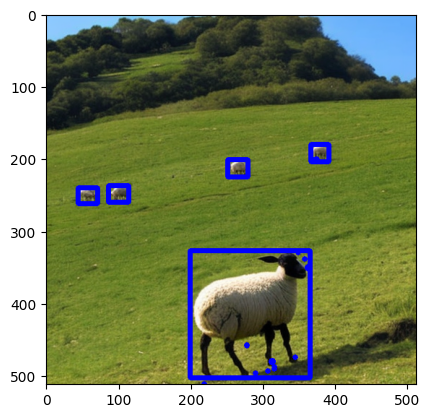

In [71]:
draw_boxes(img, boxes)

In [85]:
boxes2 = nms_boxes(boxes, min_area=)
print(len(boxes2))

[([199, 327, 365, 503], 29559), ([251, 201, 279, 225], 725), ([86, 237, 114, 260], 696), ([366, 180, 391, 204], 650), ([44, 240, 71, 262], 644)]
5


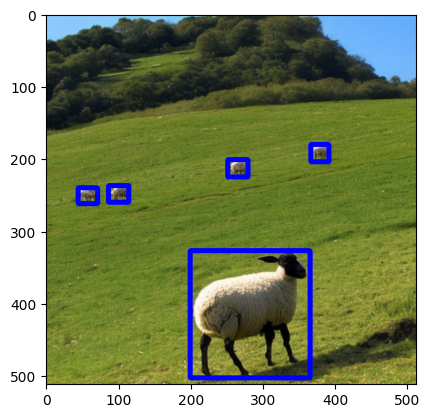

In [86]:
draw_boxes(img, boxes2)

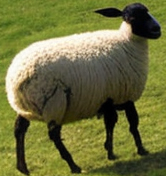

In [94]:
b = boxes2[0]
torchvision.transforms.functional.crop(Image.fromarray(img[:, :, ::-1]), b[1], b[0], b[3] - b[1], b[2] - b[0])

In [95]:
b = boxes2[1]
torchvision.transforms.functional.crop(Image.fromarray(img[:, :, ::-1]), b[1], b[0], b[3] - b[1], b[2] - b[0])